In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Data Cleaning and processing

In [121]:
#importing the data
df=pd.read_csv('C:\\Users\\Ramya\\Desktop\\All abt BA\\finance\\lcData4m.csv',na_values=['NaN','nan',' '])

In [3]:
#its clearly an imbalanced dataset
df['loan_status'].value_counts(normalize=True) 

Fully Paid     0.852608
Charged Off    0.147392
Name: loan_status, dtype: float64

In [122]:
df['verification_status']=np.where(df['verification_status']=='Source Verified',"Verified",df['verification_status'])

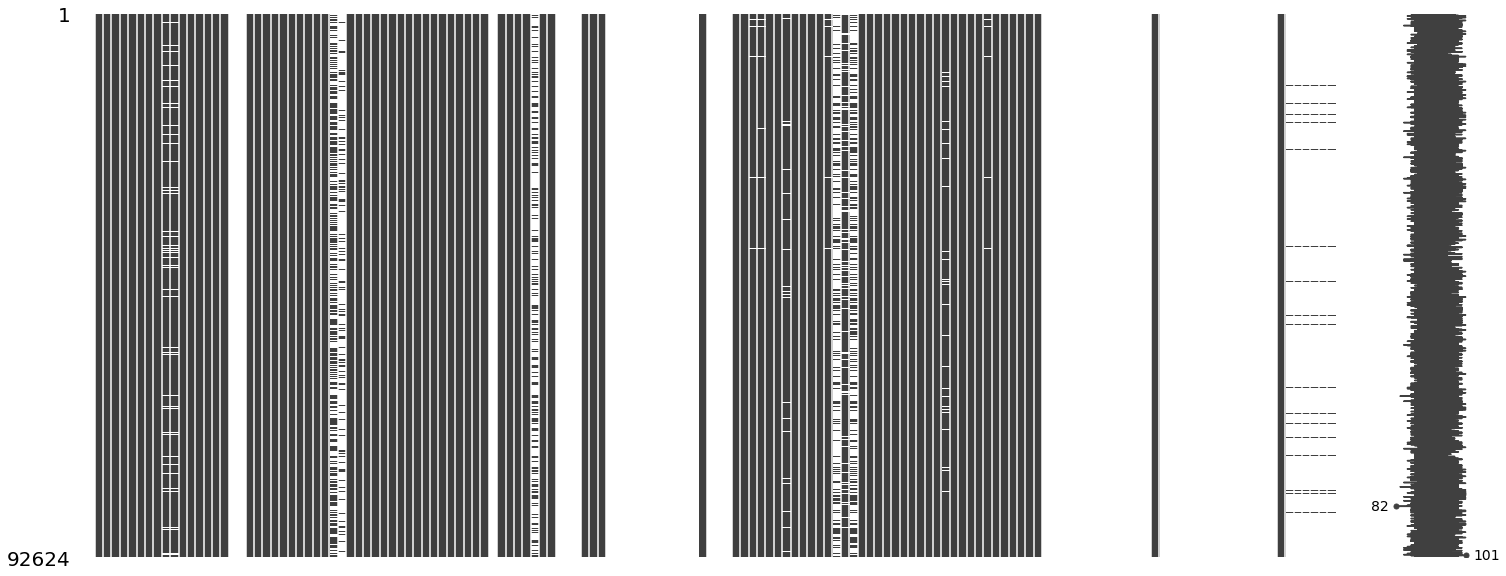

In [5]:
#check for missing values
import missingno as msno  
msno.matrix(df) 

In [123]:
#exclude all columns with missing values greater than 70% of total
df0=df.dropna(thresh=df.shape[0]*0.70,how='all',axis=1)


In [7]:
#check for missing values if any
df0[df0.columns[df0.isnull().any()]].isnull().sum()*100/df0.shape[0]


emp_title                 6.598722
emp_length                6.600881
revol_util                0.053982
last_pymnt_d              0.080973
bc_open_to_buy            0.967352
bc_util                   1.041847
mo_sin_old_il_acct        3.543358
mths_since_recent_bc      0.944680
mths_since_recent_inq    11.161254
num_tl_120dpd_2m          5.869969
percent_bc_gt_75          1.070997
dtype: float64

In [124]:
#convert certain categorical columns into numerical
df0['revol_util']=df0.revol_util.str.extract('(\d+)')
df0['revol_util']=pd.to_numeric(df0['revol_util'], downcast ='signed')

In [125]:
df0['int_rate']=df['int_rate'].replace('%','',regex=True).astype(float)


In [126]:
#replace Nan values with majority_voting in all categorical variables
for c in list(df0.select_dtypes(include=['O']).columns):
    df0[c].fillna(df0[c].value_counts().index[0],inplace=True)   

In [127]:
#replace Nan values with mean for all numerical variables
for c in list(df0.select_dtypes(exclude=['O']).columns):
    df0[c].fillna(df0[c].mean(),inplace=True)

In [12]:
category = list(df0.select_dtypes(include=['O']).columns)
sorted(category)

['addr_state',
 'application_type',
 'debt_settlement_flag',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'grade',
 'hardship_flag',
 'home_ownership',
 'initial_list_status',
 'issue_d',
 'last_credit_pull_d',
 'last_pymnt_d',
 'loan_status',
 'purpose',
 'pymnt_plan',
 'sub_grade',
 'term',
 'title',
 'verification_status',
 'zip_code']

In [13]:
#check for relation with target variable for all categorical attributes
from scipy.stats import chi2_contingency
def chi_test():
    for y in df0[category]:
        p=chi2_contingency(pd.crosstab(df['loan_status'],df[y]))[1]
        print('p-value is '+y+" "+str(p))

In [14]:
chi_test()

p-value is term 1.0
p-value is grade 0.0
p-value is sub_grade 0.0
p-value is emp_title 8.689441837551794e-05
p-value is emp_length 0.000570815911905607
p-value is home_ownership 1.9812246042308414e-111
p-value is verification_status 3.061109594596921e-101
p-value is issue_d 0.00994227539398323
p-value is loan_status 0.0
p-value is pymnt_plan 1.0
p-value is purpose 1.4677554658578412e-58
p-value is title 1.3635879891134396e-59
p-value is zip_code 9.115434887758029e-21
p-value is addr_state 6.63425935823253e-33
p-value is earliest_cr_line 3.7503852958649143e-17
p-value is initial_list_status 3.5358651533896824e-59
p-value is last_pymnt_d 0.0
p-value is last_credit_pull_d 0.0
p-value is application_type 1.0
p-value is hardship_flag 1.0
p-value is debt_settlement_flag 0.0


In [128]:
#drop columns that show no relation or uni-class columns
df0.drop(['application_type','hardship_flag','pymnt_plan','term','sub_grade','zip_code'],axis=1,inplace=True)

In [129]:
from datetime import datetime
df0["issue_d"] = pd.to_datetime(df0["issue_d"],format="%Y-%m-%dT%H:%M:%SZ")
df0["issue_d"].head()

0   2015-09-01
1   2015-09-01
2   2015-09-01
3   2015-09-01
4   2015-09-01
Name: issue_d, dtype: datetime64[ns]

In [130]:
y=[]
for i in range(0,92624):
    c=df0["last_pymnt_d"][i]
    x=datetime.strptime(str(c),'%b-%Y')
    y.append(x)

In [131]:
df0["last_pymnt_d"] =y

In [132]:
df0["last_pymnt_d"] = pd.to_datetime(df0["last_pymnt_d"])

In [20]:
df0["last_pymnt_d"].head()

0   2016-11-01
1   2016-11-01
2   2018-08-01
3   2018-03-01
4   2017-08-01
Name: last_pymnt_d, dtype: datetime64[ns]

In [133]:
diff= abs(df0.last_pymnt_d-df0.issue_d)

In [134]:
df0["duration"]=diff

In [135]:
x=[]
for i in range(0,92624):
    c=df0["last_credit_pull_d"][i]
    y=datetime.strptime(str(c),'%b-%Y')
    x.append(y)

In [136]:
df0['last_credit_pull_d']=x

In [137]:
df0["last_credit_pull_d"] = pd.to_datetime(df0["last_credit_pull_d"])

In [138]:
df0['paymnt_credit_days']=abs(df0.last_pymnt_d-df0.last_credit_pull_d)

In [27]:
df0.drop(['addr_state','earliest_cr_line','emp_title',"last_pymnt_d",'last_credit_pull_d','issue_d'],axis=1,inplace=True)

In [139]:
#for convenience replacing fully paid as 1 and chargeoff as 0
df0['loan_status']=np.where(df0['loan_status']=='Fully Paid','1','0')

In [29]:
#re-check on missing values
df0[df0.columns[df0.isnull().any()]].isnull().sum()*100/df0.shape[0]

Series([], dtype: float64)

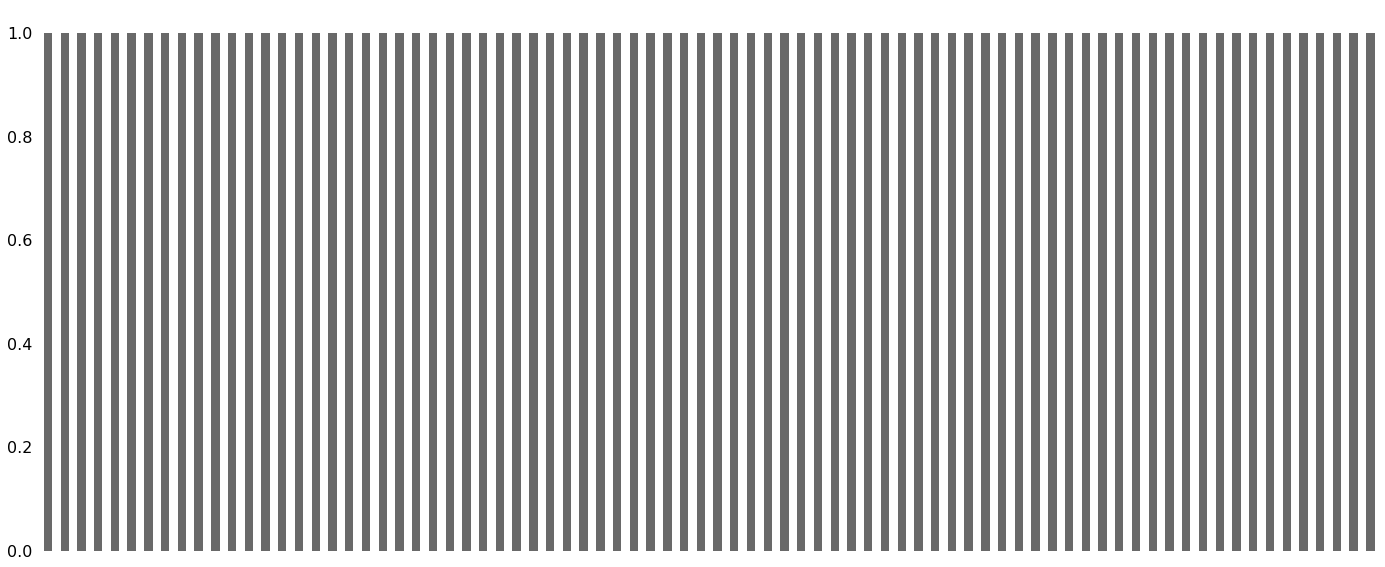

In [30]:
#visual check
msno.bar(df0)

# Feature extraction using Decision tree

In [31]:
#only categorical data in order to minimise number of dummies
cat = list(df0.select_dtypes(include=['O']).columns)
cat

['grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'loan_status',
 'purpose',
 'title',
 'initial_list_status',
 'debt_settlement_flag']

In [32]:
import datetime
df0['duration']= df0['duration'].dt.days.astype('int64')


In [33]:
df0['paymnt_credit_days']=df0['paymnt_credit_days'].dt.days.astype('int64')

In [34]:
df0['duration'].head()

0     427
1     427
2    1065
3     912
4     700
Name: duration, dtype: int64

In [35]:
#list of numerical data
num = list(df0.select_dtypes(exclude=['O']).columns)
sorted(num)


['acc_now_delinq',
 'acc_open_past_24mths',
 'annual_inc',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'duration',
 'fico_range_high',
 'fico_range_low',
 'funded_amnt',
 'funded_amnt_inv',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'last_fico_range_high',
 'last_fico_range_low',
 'last_pymnt_amnt',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'open_acc',
 'out_prncp',
 'out_prncp_inv',
 'paymnt_credit_days',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'policy_code',


In [36]:
data_num=df0[num].join(df0['loan_status'])

In [37]:
X=data_num.drop(["loan_status"],axis=1)
y=data_num['loan_status']

In [38]:

from imblearn.under_sampling import RandomUnderSampler

In [39]:
under=RandomUnderSampler(random_state=1) 
X,y=under.fit_resample(X,y)

In [40]:
X.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       '

In [41]:
import sklearn.model_selection as model_selection
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.3,random_state=200)

In [42]:
from sklearn.ensemble import RandomForestClassifier
reg=RandomForestClassifier(n_estimators=50,max_depth=3,oob_score=True,random_state=1)


In [43]:
X_train.dtypes

loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv                 int64
int_rate                      float64
installment                   float64
                               ...   
total_bal_ex_mort               int64
total_bc_limit                  int64
total_il_high_credit_limit      int64
duration                        int64
paymnt_credit_days              int64
Length: 71, dtype: object

In [44]:
X_train[X_train.columns[X_train.isnull().any()]].isnull().sum()*100/X_train.shape[0]

Series([], dtype: float64)

In [45]:
reg.fit(X_train,y_train)

RandomForestClassifier(max_depth=3, n_estimators=50, oob_score=True,
                       random_state=1)

In [46]:
reg.score(X_test,y_test)

0.95068359375

In [47]:
reg.oob_score_

0.9508162411050649

In [48]:
len(reg.estimators_)

50

In [49]:
import numpy as np
par=[]
for i in reg.estimators_:
    par.append(i.feature_importances_)

In [50]:
par=np.mean(par,axis=0)
feature_importance=pd.Series(par,index=X_train.columns.tolist()).sort_values(ascending=False)
feature_importance

last_fico_range_high       0.194436
collection_recovery_fee    0.180672
recoveries                 0.153319
last_fico_range_low        0.106569
total_rec_prncp            0.092080
                             ...   
num_tl_90g_dpd_24m         0.000000
num_tl_30dpd               0.000000
num_tl_120dpd_2m           0.000000
acc_now_delinq             0.000000
num_il_tl                  0.000000
Length: 71, dtype: float64

In [51]:
d=feature_importance[feature_importance>0.002]

In [52]:
d=list(np.array(d.index))
d

['last_fico_range_high',
 'collection_recovery_fee',
 'recoveries',
 'last_fico_range_low',
 'total_rec_prncp',
 'duration',
 'last_pymnt_amnt',
 'total_pymnt_inv',
 'total_pymnt',
 'int_rate',
 'total_rec_late_fee',
 'paymnt_credit_days',
 'funded_amnt_inv',
 'installment',
 'funded_amnt',
 'fico_range_low',
 'fico_range_high',
 'loan_amnt',
 'total_rec_int',
 'acc_open_past_24mths']

In [53]:
x=sorted(zip(map(lambda x: round(x, 4), reg.feature_importances_), X.columns),reverse=True)
x[1:17]

[(0.1807, 'collection_recovery_fee'),
 (0.1533, 'recoveries'),
 (0.1066, 'last_fico_range_low'),
 (0.0921, 'total_rec_prncp'),
 (0.0715, 'duration'),
 (0.0629, 'last_pymnt_amnt'),
 (0.0409, 'total_pymnt_inv'),
 (0.0209, 'total_pymnt'),
 (0.0132, 'int_rate'),
 (0.0121, 'total_rec_late_fee'),
 (0.0108, 'paymnt_credit_days'),
 (0.0061, 'funded_amnt_inv'),
 (0.0055, 'installment'),
 (0.0053, 'funded_amnt'),
 (0.0043, 'fico_range_low'),
 (0.0041, 'fico_range_high')]

In [54]:
import sklearn.tree as tree
clf=tree.DecisionTreeClassifier(max_depth=4,random_state=200)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4, random_state=200)

In [55]:
clf.score(X_test,y_test)

0.973388671875

In [56]:
pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False).head(7)

recoveries              0.678238
last_fico_range_high    0.159251
duration                0.063114
last_pymnt_amnt         0.058031
funded_amnt             0.023178
total_rec_prncp         0.017603
total_rec_late_fee      0.000585
dtype: float64

In [57]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
clf=BaggingClassifier(oob_score=True,n_jobs=-1,n_estimators=20,random_state=400,
                      base_estimator=DecisionTreeClassifier())

In [58]:
clf.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=20,
                  n_jobs=-1, oob_score=True, random_state=400)

In [59]:
y_train.dtypes

dtype('O')

In [60]:
clf.score(X_test,y_test)

0.986572265625

In [61]:
len(clf.estimators_)

20

In [62]:
import numpy as np
par=[]
for i in reg.estimators_:
    par.append(i.feature_importances_)

In [63]:
par=np.mean(par,axis=0)
feature_importance=pd.Series(par,index=X_train.columns.tolist()).sort_values(ascending=False)

In [64]:
e=feature_importance[feature_importance>0.004]
e=list(np.array(e.index))
e

['last_fico_range_high',
 'collection_recovery_fee',
 'recoveries',
 'last_fico_range_low',
 'total_rec_prncp',
 'duration',
 'last_pymnt_amnt',
 'total_pymnt_inv',
 'total_pymnt',
 'int_rate',
 'total_rec_late_fee',
 'paymnt_credit_days',
 'funded_amnt_inv',
 'installment',
 'funded_amnt',
 'fico_range_low',
 'fico_range_high']

In [67]:
lc=df0[e].join(df0[cat])

# Numbers giving meaningful statistics 

In [69]:
roi=lc.groupby("loan_status").agg({"total_pymnt":sum,"funded_amnt":sum})

In [70]:
roi['diff']=(roi["total_pymnt"]-roi['funded_amnt'])/roi['funded_amnt']*100

In [71]:
#loss of 36.9% and gain of 14.06%
roi 

,total_pymnt,funded_amnt,diff
loan_status,,,
0,1.072360e+08,170140500,-36.972088
1,1.166805e+09,1022906775,14.067616


In [72]:
df['loan_status'].value_counts()

Fully Paid     78972
Charged Off    13652
Name: loan_status, dtype: int64

In [73]:
pd.crosstab(df['verification_status'],df["loan_status"]) 
#22% people not verified and charged off

loan_status,Charged Off,Fully Paid
verification_status,,
Not Verified,3063,24900
Verified,10589,54072


# Model Building with all relevent attributes wrt loanStatus

In [74]:
lc['loan_status'].value_counts()

1    78972
0    13652
Name: loan_status, dtype: int64

In [75]:
lc.shape

(92624, 26)

In [76]:
lc.columns

Index(['last_fico_range_high', 'collection_recovery_fee', 'recoveries',
       'last_fico_range_low', 'total_rec_prncp', 'duration', 'last_pymnt_amnt',
       'total_pymnt_inv', 'total_pymnt', 'int_rate', 'total_rec_late_fee',
       'paymnt_credit_days', 'funded_amnt_inv', 'installment', 'funded_amnt',
       'fico_range_low', 'fico_range_high', 'grade', 'emp_length',
       'home_ownership', 'verification_status', 'loan_status', 'purpose',
       'title', 'initial_list_status', 'debt_settlement_flag'],
      dtype='object')

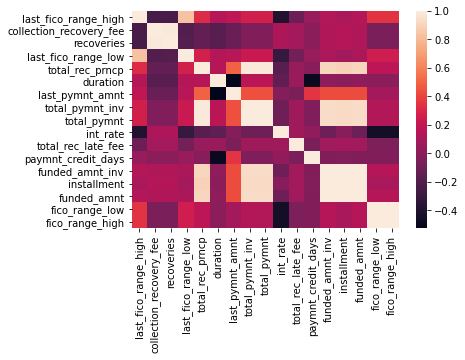

In [146]:
import seaborn as sns
sns.heatmap(lc.corr())

In [78]:
X=lc.drop(["loan_status"],axis=1)
y=lc['loan_status']

In [79]:
X=pd.get_dummies(X,prefix_sep='_')
under=RandomUnderSampler(random_state=1) #parameter replacement is false by default
X,y=under.fit_resample(X,y)

In [80]:
X.shape

(27304, 69)

In [81]:
import sklearn.model_selection as model_selection
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.2,random_state=200)

In [82]:
##################            DECISION TREE MODEL        ####################

In [83]:
import sklearn.tree as tree
clf=tree.DecisionTreeClassifier(max_depth=3,random_state=200)


In [84]:
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4, random_state=200)

In [85]:
prob=clf.predict_proba(X_test)
prob

array([[0.10035211, 0.89964789],
       [0.02868767, 0.97131233],
       [0.02868767, 0.97131233],
       ...,
       [0.10035211, 0.89964789],
       [0.02868767, 0.97131233],
       [1.        , 0.        ]])

In [86]:
import sklearn.metrics as metrics
metrics.roc_auc_score(y_test,prob[:,1])

0.9833158028582052

In [87]:
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=X.columns,  
                         class_names=["0","1"],  
                         filled=True, rounded=True,  
                       proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data) 

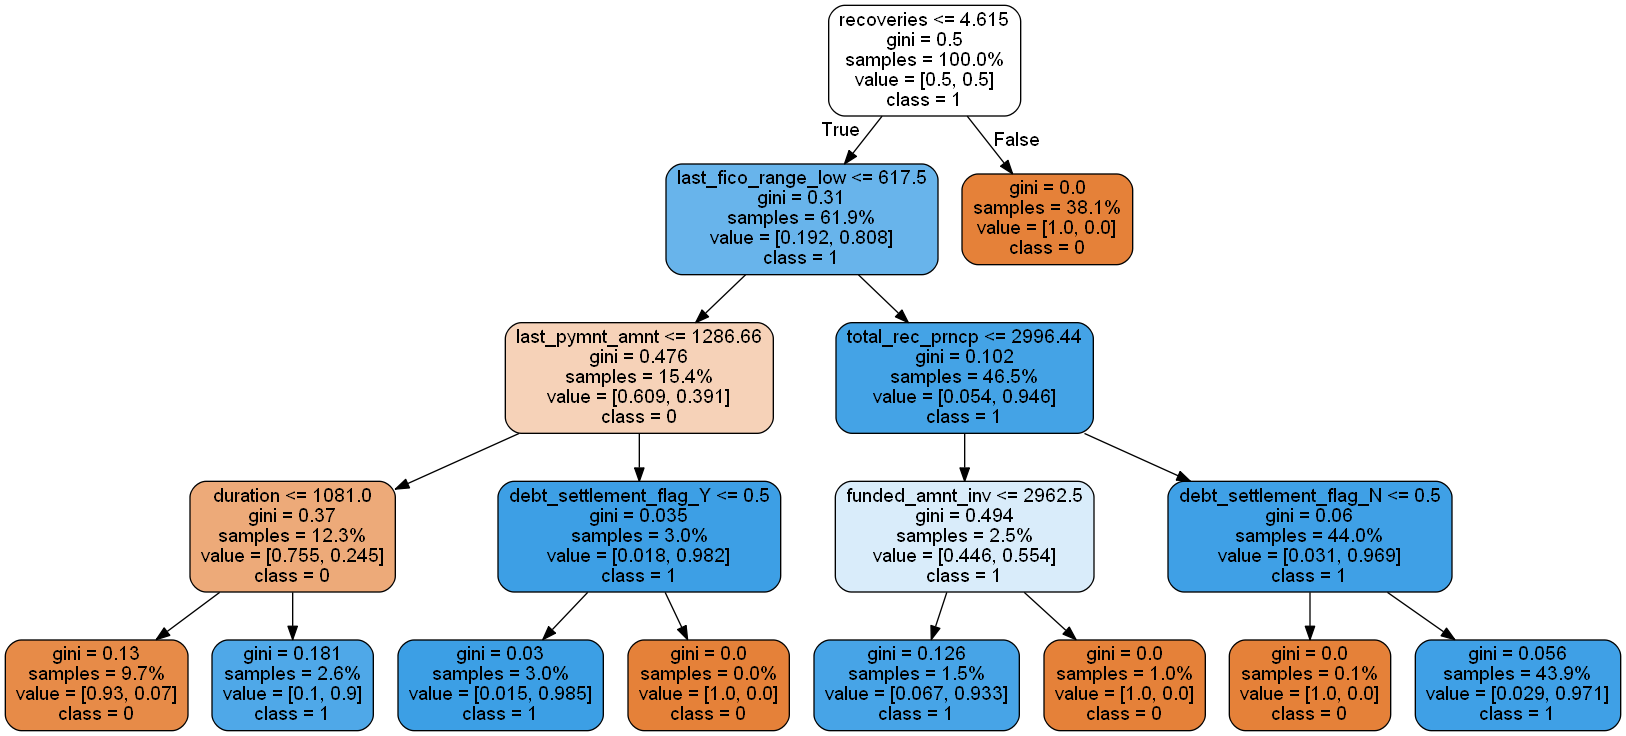

In [88]:
from IPython.display import Image
Image(graph.create_png())

In [89]:
#import sklearn.metrics as metrics
metrics.roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])

0.9833158028582052

In [90]:
#Feature importance
c=pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

In [91]:
c[c>0.02]

recoveries             0.677123
last_fico_range_low    0.156409
duration               0.062001
last_pymnt_amnt        0.058206
funded_amnt_inv        0.023153
dtype: float64

In [92]:
#######################         BAGGING ENSEMBLE METHOD       ####################


In [93]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [94]:
clf=BaggingClassifier(oob_score=True,n_jobs=-1,n_estimators=20,random_state=400,
                      base_estimator=DecisionTreeClassifier())#1=OOBSCORE,using the cores of the system,NO.OF TRESS,,BASELEARNER

In [95]:
clf.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=20,
                  n_jobs=-1, oob_score=True, random_state=400)

In [96]:
clf.score(X_test,y_test)

0.9912104010254532

In [97]:
clf.score(X_train,y_train)

0.9998168749713867

In [98]:
clf.oob_score_

0.9891040607975095

In [99]:
#######################          RANDOM FOREST     #################

In [100]:
from sklearn.ensemble import RandomForestClassifier

In [101]:
clf=RandomForestClassifier(n_estimators=80,oob_score=True,n_jobs=-1,random_state=400)
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=80, n_jobs=-1, oob_score=True,
                       random_state=400)

In [102]:
clf.oob_score_

0.9916678111980956

In [103]:
clf.score(X_test,y_test)

0.9924922175425747

In [104]:
clf.score(X_train,y_train)

1.0

In [105]:
from sklearn import metrics
metrics.roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])

0.999707467740975

In [106]:
pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False).head(20)

recoveries                 0.174621
last_fico_range_high       0.128708
last_fico_range_low        0.125816
collection_recovery_fee    0.121665
last_pymnt_amnt            0.101829
total_rec_prncp            0.081606
duration                   0.061232
total_pymnt                0.037483
total_pymnt_inv            0.029131
installment                0.021564
funded_amnt                0.019876
funded_amnt_inv            0.019338
paymnt_credit_days         0.015622
debt_settlement_flag_N     0.011969
int_rate                   0.009113
debt_settlement_flag_Y     0.008287
grade_A                    0.005824
total_rec_late_fee         0.005624
fico_range_low             0.002982
fico_range_high            0.002809
dtype: float64

In [107]:
#######################          ADA-BOOSTING      ####################

In [108]:
from sklearn.ensemble import AdaBoostClassifier
clf=AdaBoostClassifier(n_estimators=50,random_state=400)
clf.fit(X_train,y_train)

AdaBoostClassifier(random_state=400)

In [109]:
clf.score(X_train,y_train)

0.9902485922263425

In [110]:
clf.score(X_test,y_test)

0.987364951474089

In [111]:
#####################         GRADIENT BOOSTING         ##############

In [112]:
from sklearn.ensemble import GradientBoostingClassifier
clf=GradientBoostingClassifier(n_estimators=80,random_state=400)
clf.fit(X_train,y_train)

GradientBoostingClassifier(n_estimators=80, random_state=400)

In [113]:

clf.score(X_test,y_test)

0.9890130012818165

In [114]:
clf.score(X_train,y_train)

0.990889529826489

In [115]:
#lc.to_csv('C:\\Users\\Ramya\\Desktop\\All abt BA\\deep\\lendingclub.csv')

In [140]:
#df0.to_csv('C:\\Users\\Ramya\\Desktop\\All abt BA\\deep\\lending.csv')

In [116]:
lc.dtypes

last_fico_range_high         int64
collection_recovery_fee    float64
recoveries                 float64
last_fico_range_low          int64
total_rec_prncp            float64
duration                     int64
last_pymnt_amnt            float64
total_pymnt_inv            float64
total_pymnt                float64
int_rate                   float64
total_rec_late_fee         float64
paymnt_credit_days           int64
funded_amnt_inv              int64
installment                float64
funded_amnt                  int64
fico_range_low               int64
fico_range_high              int64
grade                       object
emp_length                  object
home_ownership              object
verification_status         object
loan_status                 object
purpose                     object
title                       object
initial_list_status         object
debt_settlement_flag        object
dtype: object

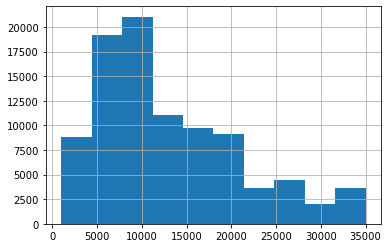

In [119]:
df['loan_amnt'].hist()

In [120]:
df['loan_amnt'].describe()

count    92624.000000
mean     12880.541490
std       8120.726668
min       1000.000000
25%       6975.000000
50%      10000.000000
75%      17475.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [ ]:
#loan issued range is 1000 to 35,000 USD
#demand and supply were normally distributed